<a href="https://colab.research.google.com/github/ankitrajput77/Deep_Learning_For_Computer_Vision/blob/main/03_Malaria_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Malaria detection using CNN

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import InputLayer, Dense, MaxPool2D, Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization

In [2]:
dataset, dataset_info = tfds.load('malaria', with_info=True, # info generator
                                  as_supervised=True, # want (image, label)
                                  shuffle_files = True, # shuffled the train data
                                  split=['train']) # choosing only train data

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompletePF0QRT/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
dataset = dataset[0]

In [4]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [5]:
for image, label in dataset:
    print((image, label))
    break

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


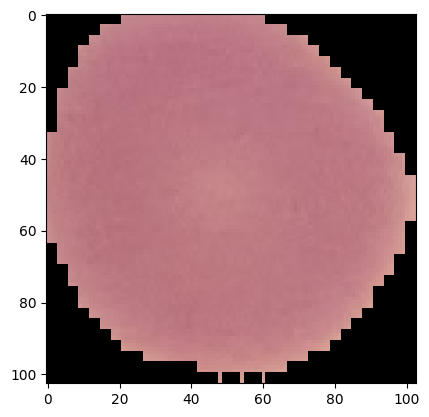

In [6]:
plt.imshow(image, cmap='gray')

In [7]:
label.numpy()

1

In [8]:
len(dataset.skip(5))

27553

In [9]:
len(dataset.take(5))

5

In [10]:
subset_dataset = dataset.take(10)
len(subset_dataset)

10

In [11]:
subset2_dataset = dataset.skip(10)
len(subset2_dataset) # len(dataset) - 10

27548

In [12]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(len(train_dataset))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(len(val_dataset))
  return train_dataset, val_dataset, test_dataset

In [13]:
len(dataset)

27558

In [14]:
train_dataset, val_dataset, test_dataset = splits(dataset, 0.8, 0.1, 0.1)

In [15]:
len(train_dataset), len(val_dataset), len(test_dataset)

(22046, 2755, 2757)

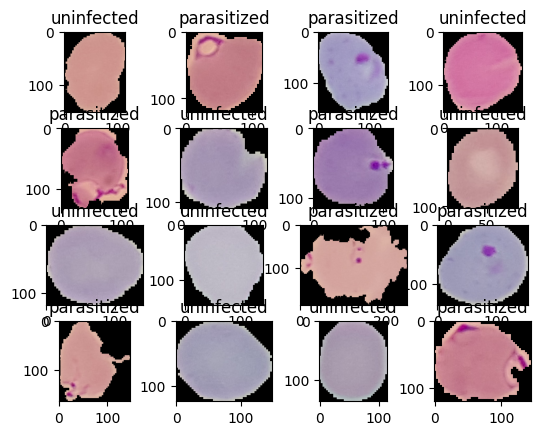

In [16]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image, cmap='gray')
  plt.title(dataset_info.features['label'].int2str(label))

In [17]:
dataset_info.features['label'].int2str(0)

'parasitized'

In [18]:
dataset_info.features['label'].int2str(1)

'uninfected'

In [19]:
def resize(image, label):
  return tf.image.resize(image, [224, 224])/255.0, label

In [20]:
train_dataset = train_dataset.map(resize)
val_dataset = val_dataset.map(resize)
test_dataset = test_dataset.map(resize)

In [21]:
for image, label in train_dataset:
    print((image, label))
    break

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)>, <tf.Tensor: shape=(), dtype=int6

In [22]:
label

<tf.Tensor: shape=(), dtype=int64, numpy=1>

In [23]:
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [41]:
len(train_dataset[0])

TypeError: ignored

# Model

In [25]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(224, 224, 3)),
    Conv2D(filters=6, kernel_size=5, strides=1, padding='valid', activation='sigmoid'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'),
    Conv2D(filters=16, kernel_size=5, strides=1, padding='valid', activation='sigmoid'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'),
    Flatten(),
    Dense(1000, activation='relu'),
    BatchNormalization(),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 6)       456       
                                                                 
 batch_normalization (BatchN  (None, 220, 220, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 batch_normalization_1 (Batc  (None, 106, 106, 16)     64        
 hNormalization)                                                 
                                                        

In [26]:
model.compile(optimizer=Adam(learning_rate=0.01),
              loss= BinaryCrossentropy(),
              metrics=['accuracy'])

In [40]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20
689/689 [==============================] - 50s 72ms/step - loss: 0.1582 - accuracy: 0.9479 - val_loss: 0.1808 - val_accuracy: 0.9514
Epoch 2/20
689/689 [==============================] - 50s 73ms/step - loss: 0.2127 - accuracy: 0.9205 - val_loss: 0.1798 - val_accuracy: 0.9539
Epoch 3/20
689/689 [==============================] - 55s 79ms/step - loss: 0.1402 - accuracy: 0.9573 - val_loss: 0.7397 - val_accuracy: 0.7666
Epoch 4/20
689/689 [==============================] - 50s 72ms/step - loss: 0.1381 - accuracy: 0.9580 - val_loss: 1.5038 - val_accuracy: 0.8657
Epoch 5/20
689/689 [==============================] - 58s 84ms/step - loss: 0.3871 - accuracy: 0.8149 - val_loss: 2441.8235 - val_accuracy: 0.5808
Epoch 6/20
689/689 [==============================] - 49s 71ms/step - loss: 0.2321 - accuracy: 0.9240 - val_loss: 0.5565 - val_accuracy: 0.8152
Epoch 7/20
689/689 [==============================] - 49s 71ms/step - loss: 0.2139 - accuracy: 0.9326 - val_loss: 13.1840 - val_accur

<Axes: >

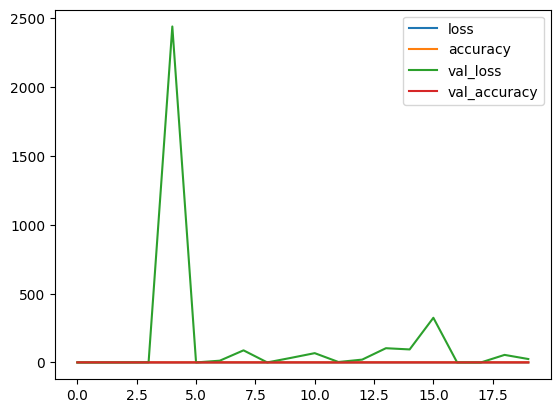

In [42]:
pd.DataFrame(history.history).plot()

In [44]:
test_dataset = test_dataset.batch(1)

In [46]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [47]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 28s 6ms/step - loss: 38.7404 - accuracy: 0.8763


[38.74039840698242, 0.8763148188591003]

In [49]:
model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 14s 14s/step


0.9993268

In [50]:
def check(x):
  if x < 0.5 :
    return str('p')
  else:
    return str('u')

1/1 [==============================] - 0s 19ms/step


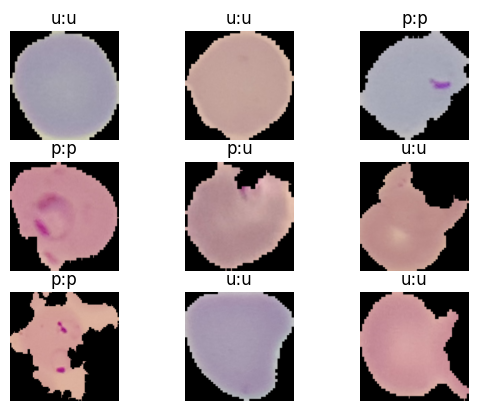

In [51]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image[0])
  plt.title(str(check(label.numpy()[0])) + ":" + str(check(model.predict(image)[0][0])))
  plt.axis('off')

In [52]:
model.save('Malaria_Diagnosis_model.h5')